In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

# обратите внимание, что Scikit-Learn импортируется как sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import scipy.stats as sps
import scipy

from tqdm import tqdm_notebook

# Базовый эксперимент на синтетическом $\sin$

Метод проведения эксперимента:

1.   Генерация выборки зашумленного синуса.

2.   Создание подвыборки

3.   Оптимизация w модели

4.   Сохранение w

5.   Пункты 1-3 много (K) раз

6. Оценка cov, E

## SSA

Здесь восстанавливается ВЕСЬ временной ряд

### 1. Генерация данных

In [50]:
sample_size = 500

x_min, x_max = -np.pi, np.pi
frequency = (x_max - x_min) / sample_size # дельта-x для наблюдений

window_size = 1 # размер окна для Ганкеля
noise_std = 0.2 # интенсивность шума

In [51]:
X = np.linspace(x_min, x_max, sample_size) # равномерно из [0, 10]
y_true = np.sin(X)
y = y_true + sps.norm(loc=0, scale=noise_std).rvs(sample_size)

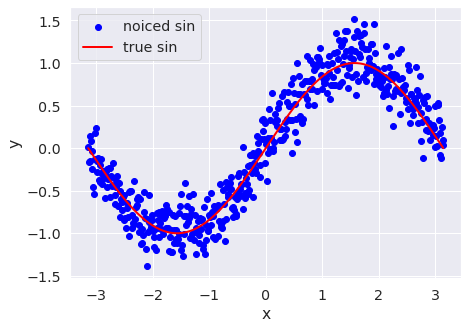

In [55]:
plt.figure(figsize=(7, 5))
plt.scatter(X, y, c='b', label='noiced sin')
plt.plot(X, y_true, color='r', linewidth=2, label='true sin')
#plt.title('$y = sin(x) + \\varepsilon$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

### 2. Код для SSA

In [72]:
def create_hankel_matrix(s: np.array, emb_size: int, step_size: int = 1) -> np.array:
    '''
        Creates hankel matrix from time series

        s:  1d time sequence
        step_size: distance between 2 following intervals
        emb_size: 

        return: H [emb_size x (n - k * (e-1))/k]
    '''

    n = len(s)

    L = (n - step_size * (emb_size-1)) // step_size
    assert L > 0, "Too big step size"
    assert emb_size <= L, "Emb > width!"

    H = np.zeros(shape=(emb_size, L))
    for i in range(emb_size):
        for j in range(L):
            H[i, j] = s[(i + j) * step_size]
    
    return H

In [73]:
test_time_serie = np.arange(10)

H = create_hankel_matrix(test_time_serie, 4, 1)
H

array([[0., 1., 2., 3., 4., 5., 6.],
       [1., 2., 3., 4., 5., 6., 7.],
       [2., 3., 4., 5., 6., 7., 8.],
       [3., 4., 5., 6., 7., 8., 9.]])

In [74]:
def get_eigenvalues_and_vectors(H: np.matrix) -> (np.array, np.matrix):
    '''
        returns eigenvalues and eigenvectors of S=H^TH

        H: [emb_size, len]
    '''

    S = H @ H.T

    _, eign_values, eign_vectors = scipy.linalg.svd(S)

    eign_vectors = eign_vectors.T # столбцы - собственные векторы

    # print(eign_vectors[:, 0][:, None].shape)

    X_s = np.array([eign_vectors[:, i][:, None] @ eign_vectors[:, i][:, None].T @ H for i in range(S.shape[0])]) # длина эмбеддинга
    return X_s, eign_vectors, eign_values

In [75]:
def hankelize(X: np.array) -> np.array:
    '''
        averaging of matrix X by anti-diagonals
    '''

    Y = np.zeros_like(X)

    for diag_num in range(X.shape[0] + X.shape[1]):
        diag_sum = 0
        diag_len = 0

        for i in range(0, X.shape[0]):
            j = diag_num - i
            if j < 0 or j >= X.shape[1]:
                continue
            
            diag_sum += X[i, j]
            diag_len += 1
        
        for i in range(0, X.shape[0]):
            j = diag_num - i
            if j < 0 or j >= X.shape[1]:
                continue

            Y[i, j] = diag_sum / diag_len
    return Y

In [76]:
assert (hankelize(H) == H).all(), 'Hank of hank matrix'

In [77]:
A = np.arange(15).reshape((3, 5))
print(A)
print(hankelize(A))

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]
[[ 0  3  6  7  8]
 [ 3  6  7  8 11]
 [ 6  7  8 11 14]]


In [78]:
def group_by_eign_incr_and_hank(X_s: np.array, eign_values: np.array, k: int) -> np.array:
    '''
        Sum all elements first and then hankelize!
        So, we use 1 large group [1, ..., k]

        X_s = [X_1, ..., X_emb_size] - components of svd decomposition. 1-rank matrices
        eign_values - corresponding to X_s
        k - number of first components used for summation
    '''
    return hankelize(X_s[:k].sum(axis=0))

In [79]:
def flatten_time_serie(H: np.array) -> np.array:
    '''
        unpack hankel matrix of time serie H to a sime serie
    '''

    s = list(H[0, :]) + list(H[1:, -1])
    return np.array(s)

In [80]:
def mse_loss(y_true, y_pred):
    return metrics.mean_squared_error(y_true, y_pred)

def mae_loss(y_true, y_pred):
    return metrics.mean_absolute_error(y_true, y_pred)

def mape_loss(y_true, y_pred):
    return metrics.mean_absolute_percentage_error(y_true, y_pred)

### 3. Применение SSA

#### a. Нарисуем зависимость качества восстановления (mape и mae) от количества компонент

Параметры модели: emb_size, k


Преследуется цель при фиксированном значении k уменьшить emb_size


(mape(y_true, y) получается очень большой, поэтому используем (y, y_true)

In [81]:
X.shape, y.shape, y_true.shape

((500,), (500,), (500,))

In [82]:
from collections import defaultdict

losses_y = defaultdict(lambda: defaultdict(lambda: dict(mse=[], mape=[]))) # k, emb_size -> mse, mape losses
losses_y_true = defaultdict(lambda: defaultdict(lambda: dict(mse=[], mape=[]))) # k, emb_size -> mse, mape losses

# emb -> {k_1: {mse, mape}}

In [ ]:
from tqdm import tqdm_notebook

for emb_size in tqdm_notebook(range(1, len(y) + 1, 10)):
    try:
        y_h = create_hankel_matrix(y, emb_size=emb_size, step_size=1)
    except:
        break

    y_s, eign_vectors, eign_values = get_eigenvalues_and_vectors(y_h)

    for k in range(1, len(y_s) + 1, 10):
        y_recovered = flatten_time_serie(group_by_eign_incr_and_hank(y_s, eign_values, k))

        losses_y[emb_size][k]['mse'].append(mse_loss(y, y_recovered))
        losses_y[emb_size][k]['mape'].append(mape_loss(y, y_recovered))

        losses_y_true[emb_size][k]['mse'].append(mse_loss(y_recovered, y_true))
        losses_y_true[emb_size][k]['mape'].append(mape_loss(y_recovered, y_true))

<ipython-input-227-27ba398a20f7>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for emb_size in tqdm_notebook(range(1, len(y) + 1, 10)):


  0%|          | 0/50 [00:00<?, ?it/s]

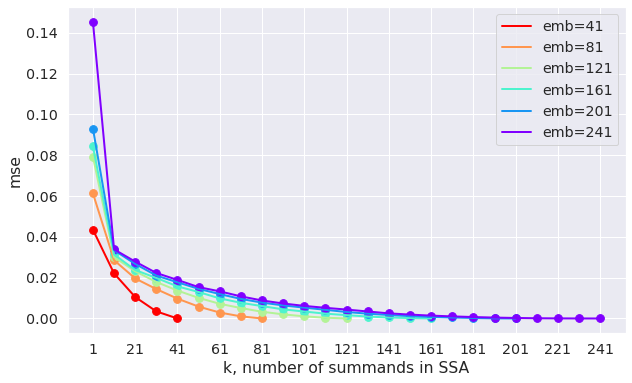

In [ ]:
import matplotlib.cm as cm

plt.figure(figsize=(10, 6))
colors = cm.rainbow(np.linspace(0, 1, len(list(losses_y.keys())[4::4])))

for c, emb_size in zip(colors[::-1], list(losses_y.keys())[4::4]):
    k_s = []
    mapes = []
    mses = []

    for k in losses_y[emb_size].keys():
        k_s.append(k)
        mapes.append(losses_y[emb_size][k]['mape'])
        mses.append(losses_y[emb_size][k]['mse'])
    #print(k_s)
    plt.plot(k_s, mses, linewidth=2, label=f'emb={emb_size}', color=c)
    plt.scatter(k_s, mses, color=c, marker='o', s=60)


plt.xlabel('k, number of summands in SSA')
plt.ylabel('mse')
plt.xticks(k_s[::2])
#plt.hlines(0.1, 0, 250)

plt.legend();

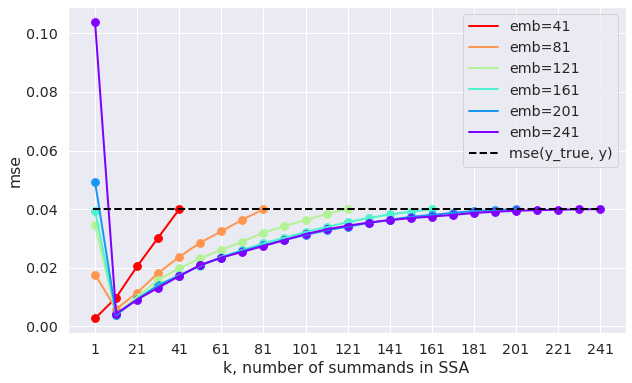

In [ ]:
import matplotlib.cm as cm

plt.figure(figsize=(10, 6))
colors = cm.rainbow(np.linspace(0, 1, len(list(losses_y_true.keys())[4::4])))

for c, emb_size in zip(colors[::-1], list(losses_y_true.keys())[4::4]):
    k_s = []
    mapes = []
    mses = []

    for k in losses_y_true[emb_size].keys():
        k_s.append(k)
        mapes.append(losses_y_true[emb_size][k]['mape'])
        mses.append(losses_y_true[emb_size][k]['mse'])
    #print(k_s)
    plt.plot(k_s, mses, linewidth=2, label=f'emb={emb_size}', color=c)
    plt.scatter(k_s, mses, color=c, marker='o', s=60)


plt.xlabel('k, number of summands in SSA')
plt.ylabel('mse')
plt.xticks(k_s[::2])
plt.hlines(mse_loss(y_true, y), 0, 241, color='black', linestyle='--', linewidth=2, label='mse(y_true, y)')

#plt.title('MSE of recovery - MSE of approximation')

plt.legend();

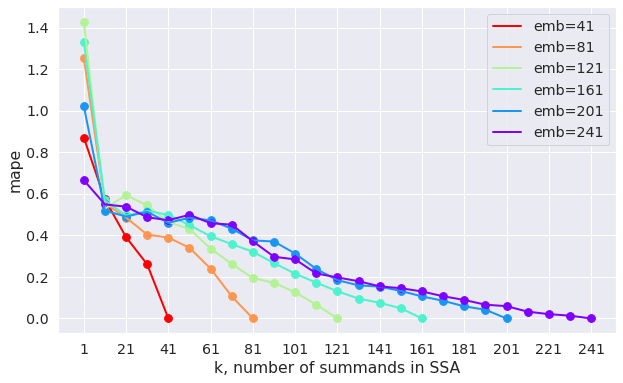

In [ ]:
import matplotlib.cm as cm

plt.figure(figsize=(10, 6))
colors = cm.rainbow(np.linspace(0, 1, len(list(losses_y.keys())[4::4])))

for c, emb_size in zip(colors[::-1], list(losses_y.keys())[4::4]):
    k_s = []
    mapes = []
    mses = []

    for k in losses_y[emb_size].keys():
        k_s.append(k)
        mapes.append(losses_y[emb_size][k]['mape'])
        mses.append(losses_y[emb_size][k]['mse'])
    #print(k_s)
    plt.plot(k_s, mapes, linewidth=2, label=f'emb={emb_size}', color=c)
    plt.scatter(k_s, mapes, color=c, marker='o', s=60)

plt.xlabel('k, number of summands in SSA')
plt.ylabel('mape')
plt.xticks(k_s[::2])
#plt.hlines(0.1, 0, 250)

plt.legend();

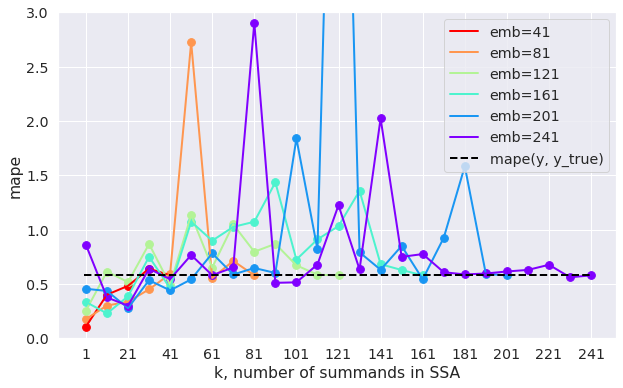

In [ ]:
import matplotlib.cm as cm

plt.figure(figsize=(10, 6))
colors = cm.rainbow(np.linspace(0, 1, len(list(losses_y_true.keys())[4::4])))

for c, emb_size in zip(colors[::-1], list(losses_y_true.keys())[4::4]):
    k_s = []
    mapes = []
    mses = []

    for k in losses_y_true[emb_size].keys():
        k_s.append(k)
        mapes.append(losses_y_true[emb_size][k]['mape'])
        mses.append(losses_y_true[emb_size][k]['mse'])
    #print(k_s)
    # print(mapes)
    plt.plot(k_s, mapes, linewidth=2, label=f'emb={emb_size}', color=c)
    plt.scatter(k_s, mapes, color=c, marker='o', s=60)

plt.xlabel('k, number of summands in SSA')
plt.ylabel('mape')
plt.xticks(k_s[::2])
plt.hlines(mape_loss(y, y_true), 0, 241, color='black', linestyle='--', linewidth=2, label='mape(y, y_true)')
plt.ylim(0, 3)
plt.legend();

## Используем нейросеть 

$\mathbf{f}(x) = \sigma(w^{\mathsf{T}}\cdot \sigma(W^{\mathsf{T}}x + b_1) + b_2)$

$\ x \in \mathbb{R}^{h}, \ W \in \mathbb{R}^{h \times d}, \ b_1 \in \mathbb{R}^h, \ b_2 \in \mathbb{R}, \ w \in \mathbb{R}^d: w^Tw=1, WW^T=I.$

Здесь вопрос: восстанавливается ??? временного ряда.

Длина входа: 1% от длины сигнала (-> 100 батчей).
Длина выхода: 2% от длины сигнала.

Временной ряд $s \in [-1, 1]$.
Выходная активация $tanh$, промежуточная - $sigmoid$.


### 1. Генерация данных

In [ ]:
sample_size = 5000

x_min, x_max = -np.pi, np.pi
frequency = (x_max - x_min) / sample_size # дельта-x для наблюдений

window_size = 1 # размер окна для Ганкеля
noise_std = 0.2 # интенсивность шума

In [ ]:
X = np.linspace(x_min, x_max, sample_size) # равномерно из [0, 10]
y_true = np.sin(X)
y = y_true + sps.norm(loc=0, scale=noise_std).rvs(sample_size)

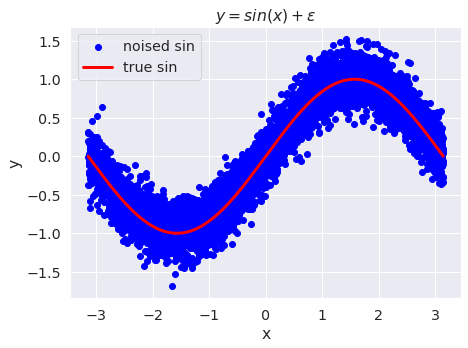

In [ ]:
plt.figure(figsize=(7, 5))
plt.scatter(X, y, c='b', label='noised sin')
plt.plot(X, y_true, color='r', linewidth=3, label='true sin')
plt.title('$y = sin(x) + \\varepsilon$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

### 2. Код нейросети и даталоадеров

In [ ]:
!pip install geotorch

In [ ]:
import torch
import torch.nn as nn
import geotorch

# Datasets
from torch.utils.data import Dataset
from torchvision import datasets

# On top of dataset for batching, shuffle, ...
from torch.utils.data import DataLoader

In [ ]:
class TimeSerie_1d_Dataset(Dataset):
    def __init__(self, in_len: int, out_len: int, s_noice: np.array, s_true: np.array = None):
        '''
            s = [s_1, s_2, ... ]- 1d time serie
            in_len - length of sequence of following time measurements
            out_len - length of predictions (the last of in_len elements)

            ds[1] = [s_1, ..., s_k]
        '''

        assert s_noice.shape == s_true.shape

        self.s_noice = torch.FloatTensor(s_noice)
        self.s_true = torch.FloatTensor(s_true)
        self.in_len = in_len
        self.out_len = out_len
    
    def __len__(self):
        return len(self.s_noice) - (self.in_len - 1) - max(0, self.out_len - self.in_len)
    
    def __getitem__(self, idx):
        '''
            the 0-th element has index max(out_len - in_len, 0)
        '''
        assert idx >= 0, 'idx [left] out of range'
        assert idx < len(self), 'idx [right] out of range'
        
        right_idx = idx + max(0, self.out_len - self.in_len)
        
        return self.s_noice[idx:idx + self.in_len], \
               self.s_noice[idx + self.in_len - self.out_len: idx + self.in_len], \
               self.s_true[idx + self.in_len - self.out_len: idx + self.in_len]

        # assert idx + self.in_len <= len(self.s), 'idx [right] out of range'
        # assert idx + self.in_len - self.out_len >= 0, 'idx [left] out of range'
        # assert idx >= 0, 'idx [zero] out of range'
        # return self.s[idx:idx + self.in_len], self.s[idx + self.in_len - self.out_len, idx + self.in_len]

In [ ]:
test_time_serie = np.arange(10)

print(test_time_serie)

ds = TimeSerie_1d_Dataset(3, 2, test_time_serie, test_time_serie)
print(ds[0], ds[7], len(ds))

dataloader = DataLoader(ds, batch_size=3, shuffle=True)
print(next(iter(dataloader)))

[0 1 2 3 4 5 6 7 8 9]
(tensor([0., 1., 2.]), tensor([1., 2.]), tensor([1., 2.])) (tensor([7., 8., 9.]), tensor([8., 9.]), tensor([8., 9.])) 8
[tensor([[7., 8., 9.],
        [1., 2., 3.],
        [5., 6., 7.]]), tensor([[8., 9.],
        [2., 3.],
        [6., 7.]]), tensor([[8., 9.],
        [2., 3.],
        [6., 7.]])]


In [ ]:
class NN_2_orthogonal(nn.Module):
    def __init__(self, in_len, hid_dim, out_len):
        super().__init__()
        # One line suffices: Instantiate a linear layer with orthonormal columns
        self.W1 = nn.Linear(in_len, hid_dim, bias=True)
        geotorch.orthogonal(self.W1, "weight")
        self.act1 = nn.Sigmoid()

        self.W2 = nn.Linear(hid_dim, out_len, bias=True)
        geotorch.orthogonal(self.W2, "weight")
        self.act2 = nn.Tanh()

    def forward(self, x):
        # self.linear is orthogonal and every 3x3 kernel in self.cnn is of rank 1
        x = self.W1(x)
        x = self.act1(x)

        x = self.W2(x)
        x = self.act2(x)

        return x

In [ ]:
def model_num_params(model):
    sum_params = 0
    for param in model.named_parameters():
        num_params = np.prod(param[1].shape)
        print('{: <19} ~  {: <7} params'.format(param[0], num_params))
        sum_params += num_params
    print(f'\nIn total: {sum_params} params')
    return sum_params

In [ ]:
def train_one_epoch(model, optimizer, loader, criterion, device='cpu'):
    model.train()
    losses_tr = []
    losses_train_true = []

    for batch, y, y_true in loader:
        batch = batch.to(device)
        y = y.to(device)
        y_true = y_true.to(device)
        # batch = [batch_size, seq_len]

        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item()) 

        loss_true = criterion(out, y_true)
        losses_train_true.append(loss_true.item())

    return model, optimizer, np.mean(losses_tr), np.mean(losses_train_true)

In [ ]:
def validate(model, loader, criterion, device='cpu'):
    model.eval()

    losses = []
    losses_true = []

    with torch.no_grad():
        for batch, y, y_true in loader:
            batch = batch.to(device)
            y = y.to(device)
            y_true = y_true.to(device)

            out = model(batch)
            loss = criterion(out, y)

            losses.append(loss.item())

            loss_true = criterion(out, y_true)
            losses_true.append(loss_true.item())
    
    return np.mean(losses), np.mean(losses_true)

In [ ]:
from IPython.display import clear_output
from tqdm.notebook import trange

def learning_loop(model, optimizer, loader, criterion, epochs=10, val_every=1, draw_every=1, separate_show=False, device='cpu'):
    losses = {'train': [], 'val': []}
    losses_true = {'train': [], 'val': []}

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        model, optimizer, loss, loss_true = train_one_epoch(model, optimizer, loader, criterion, device)
        losses['train'].append(loss)
        losses_true['train'].append(loss_true)

        if not (epoch % val_every):
            loss, loss_true = validate(model, loader, criterion, device)
            losses['val'].append(loss)
            losses_true['val'].append(loss_true)

        if not (epoch % draw_every):
            clear_output(True)
            fig, ax = plt.subplots(1, 2 if separate_show else 1, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            if separate_show:
                plt.subplot(121)
                plt.title('loss on train')
            plt.plot(losses['train'], 'r.-', linewidth=2, label='train-noice')
            plt.plot(losses_true['train'], 'g.-', linewidth=2, label='train-true')

            plt.xlabel('epoch')
            plt.ylabel('mse')
            plt.legend()

            if separate_show:
                plt.subplot(122)
                plt.title('loss on validation')
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'r.-', linewidth=2, label='val-noice')
            plt.plot(losses_true['val'], 'g.-', linewidth=2, label='val-true')

            plt.xlabel('epoch')
            plt.ylabel('mse')
            plt.legend()
            
            plt.show()
    
    return model, optimizer, losses, losses_true

### 3. Обучение модели

In [40]:
in_len = 20
hid_dim = 2
out_len = 20

batch_size = 16
lr = 3e-4

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:0


In [41]:
dataset = TimeSerie_1d_Dataset(in_len=in_len, out_len=out_len, s_noice=y, s_true=y_true)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [42]:
model = NN_2_orthogonal(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [ ]:
model, optimizer, losses, losses_true = learning_loop(
    model = model,
    optimizer = optimizer,
    loader = dataloader,
    criterion = criterion,
    epochs = 30,
    separate_show=True,
    device=device
)

### 4. Создание выборки из N=100 моделей. Оценка дисперсии методом bootstrap.

Обучаем 7 эпох (как видно, этого достаточно)

Архитектура: (20, 2, 20), то есть двумерное признаковое пространство.

Будем пробовать визуализировать матрицу W2 (ее строки)

In [44]:
import pickle
path = '/content/drive/MyDrive/metric analysis/2NN experiment'

In [45]:
N = 100
max_epochs = 7

In [ ]:
from tqdm import tqdm_notebook

models = []
losses = []

for i in tqdm_notebook(range(N)):
    model = NN_2_orthogonal(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model, optimizer, losses_tr, losses_true_tr = learning_loop(
        model = model,
        optimizer = optimizer,
        loader = dataloader,
        criterion = criterion,
        epochs = max_epochs,
        val_every=max_epochs+1, 
        draw_every=max_epochs+1,
        separate_show=True,
        device=device
    )

    models.append(model)
    losses.append(losses_true_tr['train'][-1])
    print(f'Loss #{i + 1}: {losses_true_tr["train"][-1]:.3f}')

    torch.save(model.state_dict(), path + f"/nn_{i + 1}.pth")

In [47]:
np.var(losses)

5.7965873719515986e-05

In [48]:
np.mean(losses), np.max(losses), np.min(losses)

(0.3619873549951575, 0.38705182357285267, 0.353175037039014)

### 5. Для 3-х мерного пространства

In [62]:
in_len = 20
hid_dim = 3
out_len = 20

batch_size = 16
lr = 1e-3

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:0


In [63]:
dataset = TimeSerie_1d_Dataset(in_len=in_len, out_len=out_len, s_noice=y, s_true=y_true)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [64]:
model = NN_2_orthogonal(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

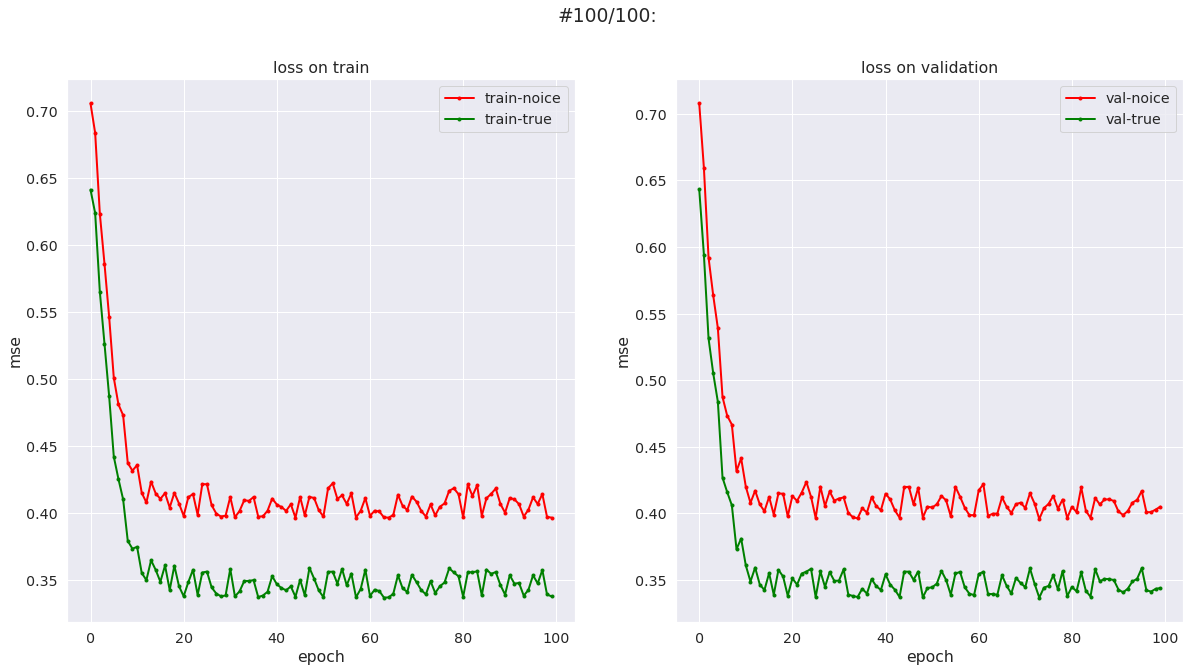

In [65]:
model, optimizer, losses, losses_true = learning_loop(
    model = model,
    optimizer = optimizer,
    loader = dataloader,
    criterion = criterion,
    epochs = 100,
    draw_every=10,
    separate_show=True,
    device=device
)

In [66]:
import pickle
path = '/content/drive/MyDrive/metric analysis/2NN experiment_3d'

In [67]:
N = 100
max_epochs = 20

In [ ]:
from tqdm import tqdm_notebook

models = []
losses = []

for i in tqdm_notebook(range(N)):
    model = NN_2_orthogonal(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model, optimizer, losses_tr, losses_true_tr = learning_loop(
        model = model,
        optimizer = optimizer,
        loader = dataloader,
        criterion = criterion,
        epochs = max_epochs,
        val_every=max_epochs+1, 
        draw_every=max_epochs+1,
        separate_show=True,
        device=device
    )

    models.append(model)
    losses.append(losses_true_tr['train'][-1])
    print(f'Loss #{i + 1}: {losses_true_tr["train"][-1]:.3f}')

    torch.save(model.state_dict(), path + f"/nn_{i + 1}.pth")

In [69]:
np.var(losses)

9.876366055371426e-05

In [70]:
np.mean(losses), np.max(losses), np.min(losses)

(0.35267676589634983, 0.3848592802401512, 0.3376767137838948)

### Визуализация для 3-х мерного пространства

In [71]:
def visualize_feature_space_linreg(w_mean, i, j, N=50):
    ABSi = np.abs(w_mean[i])
    ABSj = np.abs(w_mean[j])

    w_is = np.linspace(w_mean[i] - ABSi * 3, w_mean[i] + ABSi * 3, N)
    w_js = np.linspace(w_mean[j] - ABSj * 3, w_mean[j] + ABSj * 3, N)

    W_is, W_js = np.meshgrid(w_is, w_js)

    Ls = np.zeros_like(W_is)

    for i1 in range(W_is.shape[0]):
        for j1 in range(W_is.shape[1]):
            w = w_mean.copy()
            w[i] = W_is[i1][j1]
            w[j] = W_js[i1][j1]
            Ls[i1][j1] = L(w, data)
    

    plt.figure(figsize=(7, 7))
    norm = plt.Normalize(Ls.min(), Ls.max())
    colors = cm.jet(norm(Ls))

    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(W_is, W_js, Ls, facecolors=colors, shade=False)
    surf.set_facecolor((0,0,0,0))

    ax.set_title(f'$L(w_{i}, w_{j})$');
    ax.set_xlabel(f'$w_{i} = {features[i]}$')
    ax.set_ylabel(f'$w_{j} = {features[j]}$')
    ax.set_zlabel(f'$L(w_{i}, w_{j})$')

    # ax.zaxis.set_major_locator(LinearLocator(1))
    # ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    #ax.view_init(azim=50)
    ax.zaxis.set_major_locator(LinearLocator(10))

In [ ]:
W = models[0